In [1]:
# This time will be using discree count data

import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Read in model data - round level (37,676)
model_data = pd.read_csv('C:\\KF_Repo\\PGA_Golf\\Tournament_level_model\\Data_manipulation\\model_data.csv')


# Group by count using pandas groupby()
grouped_data = model_data.groupby(['tournament id', 'Round'])['Round_total'].mean().reset_index()

# Rename columns
grouped_data = grouped_data.rename(columns={"tournament id": "tournament id", 
                                            "Round": "Round",
                                            "Round_total": "Avg_Score"})

# Round Avg Score to 2 decimal places (same as strokes gained)
grouped_data['Avg_Score'] = grouped_data['Avg_Score'].round(2)

# Merge dataframes by 'tournament.id' and 'Round'
add_avg = pd.merge(model_data, grouped_data, on=['tournament id', 'Round'])


# Add difference - put same format as strokes gained
# Negative is bad, positive is good
add_avg['Round_sg'] = add_avg['Avg_Score'] - add_avg['Round_total']

# Filter data for players that you want to analyze
my_players = ['Seamus Power', 'Tony Finau']
mydata2 = add_avg[add_avg['player'].isin(my_players)]

# Convert date to datetime format
mydata2['date'] = pd.to_datetime(mydata2['date'])

# Add in a column for date of round
mydata2['date_round'] = mydata2['date'] + pd.to_timedelta(mydata2['Round'] - 4, unit='D')

# Find the earliest date
earliest_date = mydata2['date_round'].min()

# Calculate the time column
mydata2['time'] = (mydata2['date_round'] - earliest_date).dt.days

# Create a sequence of unique dates and assign corresponding time values
unique_dates = mydata2['date_round'].unique()
date_to_time_mapping = pd.DataFrame({'date_round': unique_dates, 'time_2': np.arange(len(unique_dates))})

# Merge the mapping with the original dataframe
mydata2 = pd.merge(mydata2, date_to_time_mapping, on='date_round', how='left')

# Concatenate columns with "_"
unique_tr = mydata2[['tournament name','date_round', 'Round']].drop_duplicates()
unique_tr['cr'] = unique_tr['tournament name'].astype(str) + "_"+ unique_tr['date_round'].astype(str) + "_" +"R"+ unique_tr['Round'].astype(str)

# Concatenate columns with "_"
unique_tourn = mydata2[['tournament name', 'date']].drop_duplicates()
unique_tourn['tourn'] = unique_tourn['tournament name'].astype(str) + "_" + unique_tourn['date'].astype(str)

# Create additional dataframe before filter
mydata_all = pd.merge(mydata2, unique_tr, on=['tournament name','date_round', 'Round'], how='left')
mydata_all = pd.merge(mydata_all, unique_tourn, on=['tournament name', 'date'], how='left')

# Keep using mydata2
mydata2 = pd.merge(mydata2, unique_tr, on=['tournament name','date_round', 'Round'], how='left')
mydata2 = pd.merge(mydata2, unique_tourn, on=['tournament name', 'date'], how='left')


# Filter train and test data
train_data = mydata_all[mydata_all['date_round'] <= "2020-08-30"]
test_data = mydata_all[mydata_all['date_round'] > "2020-08-30"]

# Perform Regression on training data
reg_data = train_data

# Filter by player
power = reg_data[reg_data['player'] == "Seamus Power"]

# Order by date round
power = power.sort_values(by='date_round')

# Create a time series object - Change this to round total
ts_data = pd.Series(power['Round_total'].values, index=power['date_round'])

## partition into train and test
train_series = ts_data[:80]
test_series = ts_data[80:103]


C:\Users\killi\AppData\Local\Temp/ipykernel_18112/3665337522.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata2['date'] = pd.to_datetime(mydata2['date'])
C:\Users\killi\AppData\Local\Temp/ipykernel_18112/3665337522.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata2['date_round'] = mydata2['date'] + pd.to_timedelta(mydata2['Round'] - 4, unit='D')
C:\Users\killi\AppData\Local\Temp/ipykernel_18112/3665337522.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

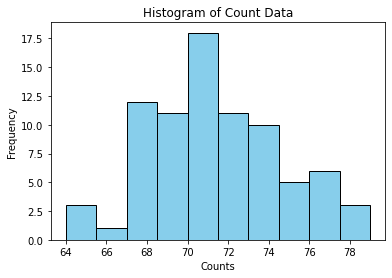

mean  71.2125
std  3.2353274563790295
var  10.467343750000001


In [2]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(train_series, bins=10, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.title('Histogram of Count Data')

# Display the plot
plt.show()

# calculate standard dev of generated values
# Mean is far greater than Variance so poisson not appropriate
print('mean ',np.mean(train_series))
print('std ',np.std(train_series))
print('var ',np.var(train_series))


In [3]:
# Create statsmodels generalised
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Add constant column to X
X = sm.add_constant(train_series)

# GP1 Model

gen_poisson_gp1 = sm.GeneralizedPoisson(train_series.values, X['const'].values, p=1)

gen_poisson_gp1_results = gen_poisson_gp1.fit()

print(gen_poisson_gp1_results.summary())

# GP2 Model
# WHy is the coefficient 4 if my data has values in the 72

gen_poisson_gp2 = sm.GeneralizedPoisson(train_series.values, X['const'].values, p=2)

gen_poisson_gp2_results = gen_poisson_gp2.fit()

print(gen_poisson_gp2_results.summary())


         Current function value: 3.037565
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 4
                    GeneralizedPoisson Regression Results                     
Dep. Variable:                      y   No. Observations:                   80
Model:             GeneralizedPoisson   Df Residuals:                       79
Method:                           MLE   Df Model:                            0
Date:                Fri, 10 May 2024   Pseudo R-squ.:                 -0.1692
Time:                        22:10:29   Log-Likelihood:                -243.01
converged:                      False   LL-Null:                       -207.84
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2657        nan        nan        nan         nan         nan


C:\Users\killi\anaconda3\envs\stan_2\lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\killi\anaconda3\envs\stan_2\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
import numpy as np
from scipy.special import gammaln

def log_likelihood(params, endog, predict, p, _transparams=True):
    if _transparams:
        alpha = np.exp(params[-1])
    else:
        alpha = params[-1]
    params = params[:-1]
    
    mu = predict(params)
    mu_p = np.power(mu, p)
    a1 = 1 + alpha * mu_p
    a2 = mu + (a1 - 1) * endog
    a1 = np.maximum(1e-20, a1)
    a2 = np.maximum(1e-20, a2)
    
    return np.sum(np.log(mu) + (endog - 1) * np.log(a2) - endog * np.log(a1) - gammaln(endog + 1) - a2 / a1)


In [4]:
import numpy as np
from scipy.special import gammaln

# theta is mean
# lambda is alpha
# lambda is supposed to lie between 0 and 1
# This may not account for under dispersion
def dgp(y, theta, lmbda, logged=True):
    den = np.log(theta) + (y - 1) * np.log(theta + lmbda * y) - theta - y * lmbda - gammaln(y + 1)
    if not logged:
        den = np.exp(den)
    return den


In [ ]:
# Maximum Likelihood Estimation
# estimating parameters that maximise the likelihood so that observed data belongs to distribution

# In likelihood function - maximise theta for data x1,x2,x3
# Likelihood will have a value
# Likelihood is the probability density function
# combined likelihood of all n points is product of individual likelihoods
# can find derivative of likelihood and set it to 0
# can then solve for parameter

In [15]:
np.exp(1)

2.718281828459045

In [20]:
np.log(dgp(50,71.2125,-0.0086,False))

-6.273620631691074

In [14]:
dgp(72,71.2125,-0.0086,True)

-3.063619217664126

In [192]:
from scipy.stats import poisson

def poisson_probability_range(rate, lower_bound, upper_bound):
    lower_prob = poisson.cdf(lower_bound, rate)
    upper_prob = poisson.cdf(upper_bound, rate)
    return upper_prob - lower_prob

rate = 71.2125
lower_bound = 0
upper_bound = 72

probability = poisson_probability_range(rate, lower_bound, upper_bound)
print("Probability:", probability)


Probability: 0.5682171105579453


In [5]:
# -0.0086
# I think I have the pdf now
total_percentage = 0
for i in range(50, 100):
    percentage = dgp(i,71.2125,-0.0086,False)
    total_percentage += percentage  # Accumulate percentage in total_percentage
    print(f"Percentage for {i}: {percentage}")

print("Total percentage:", total_percentage)

Percentage for 50: 0.0018853899080674523
Percentage for 51: 0.0026233325957243383
Percentage for 52: 0.0035790395643504297
Percentage for 53: 0.004789621908706986
Percentage for 54: 0.006289442761830549
Percentage for 55: 0.008106777486927471
Percentage for 56: 0.010260134535584562
Percentage for 57: 0.012754547830458974
Percentage for 58: 0.015578224493717891
Percentage for 59: 0.018699966554318683
Percentage for 60: 0.022067769646094675
Percentage for 61: 0.025608929777861042
Percentage for 62: 0.029231863531213452
Percentage for 63: 0.0328296790390344
Percentage for 64: 0.03628534429896045
Percentage for 65: 0.03947811059569404
Percentage for 66: 0.042290688380590774
Percentage for 67: 0.04461656443314416
Percentage for 68: 0.046366809273524455
Percentage for 69: 0.047475759693020064
Percentage for 70: 0.04790506907796539
Percentage for 71: 0.047645783788440164
Percentage for 72: 0.04671830515986662
Percentage for 73: 0.04517030736786273
Percentage for 74: 0.04307287495498351
Percen

In [ ]:
# theta is mean
# lambda is alpha
# lambda is supposed to lie between 0 and 1
# This may not account for under dispersion

def dgp(y, theta, lmbda, logged=True):
    den = np.log(theta) + (y - 1) * np.log(theta + lmbda * y) - theta - y * lmbda - gammaln(y + 1)
    if not logged:
        den = np.exp(den)
    return den


In [6]:
import pandas as pd
import numpy as np
import pystan
import arviz as az
import matplotlib.pyplot as plt

# Try putting log in pmf formula

model_code = """

functions {
    real dgp(int k, real lambda, real a) {
        real pmf;
            pmf = log(log(lambda) + (k - 1) * log(lambda + a * k) - lambda - k * a - lgamma(k + 1));
        return pmf;
    }
}

data {
  int<lower=0> N; //number of rows in training set
  int<lower=0> y[N]; // need to change this from vector(real)
} 

parameters {  
// set golfer mean and disperson parameter
  real  golfer_lambda;
  real <upper=0> golfer_alpha ;  
} 

model {
    // set priors
    // golfer_lambda ~ normal(72,3);
    // golfer_alpha ~ normal(0,1);

    // Likelihood using dgp
    // removed log
    for (i in 1:N)
        target += dgp(y[i], golfer_lambda, golfer_alpha);
}


"""

# Create Model - this will help with recompilation issues
# THis runs to compiling stage - takes a while
stan_model = pystan.StanModel(model_code=model_code)





INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b947c2a09dcb99712ab1d45f2dca0ccd NOW.


In [7]:
# Set observed data to now use round score instead of to par
observed_round_score = train_series.values

model_data = {'N': len(observed_round_score),
               'y': observed_round_score}

# Initial values for the parameters
init_values = {'golfer_lambda': 70.5,
               'golfer_alpha': -0.5}

In [9]:
import pystan

print("PyStan version:", pystan.__version__)


PyStan version: 2.19.1.1


In [ ]:
import pystan

# Assuming you have already compiled your Stan model and defined your model code, data, and initial values

# Compile your Stan model
stan_model = pystan.StanModel(model_code=model_code)

# Define your initial values
init_values = {
    'parameter_1': 0,  # Set initial value for parameter 1
    'parameter_2': 0   # Set initial value for parameter 2
    # Add more parameters as needed
}

# Sample from the model with specified initial values
fit = stan_model.sampling(data=model_data, iter=1000, chains=4, init=[init_values]*4)

# Check for any warnings or error messages during sampling
print("Warnings:", fit.get_warnings())

# Print summary of the sampling results
print(fit)

# Access convergence diagnostics (e.g., R-hat values)
print("R-hat values:", fit.summary()['summary'][:, fit.summary()['summary_colnames'].index('Rhat')])


In [11]:
import pystan

# Assuming you have already compiled your Stan model and defined your model code, data, and initial values

# Compile your Stan model
stan_model = pystan.StanModel(model_code=model_code)



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b947c2a09dcb99712ab1d45f2dca0ccd NOW.


Initialization failed: Initialization failed.


NameError: name 'fit' is not defined

In [12]:
init_values = {'golfer_lambda': 70.5,
               'golfer_alpha': -0.5}

# Sample from the model with specified initial values
try:
    fit = stan_model.sampling(data=model_data, iter=1000, chains=4, init=[init_values]*4)
except RuntimeError as e:
    print("Initialization failed:", e)

# Check for any warnings or error messages during sampling
print("Warnings:", fit.get_warnings())

# Print summary of the sampling results
print(fit)

# Access convergence diagnostics (e.g., R-hat values)
print("R-hat values:", fit.summary()['summary'][:, fit.summary()['summary_colnames'].index('Rhat')])


Initialization failed: Initialization failed.


NameError: name 'fit' is not defined

In [14]:
fit.get_warnings()

NameError: name 'fit' is not defined

In [10]:
# fit model
fit = stan_model.sampling(data=model_data, iter=2000, chains=1, seed = 1, init=[init_values])
# Check for any warnings or error messages during sampling
print("Warnings:", fit.get_warnings())

RuntimeError: Initialization failed.

In [ ]:

# Put Posterior draws into a dictionary
#trace = fit.extract()


# Put simulations into an array
#y_sim = trace['y_sim']

# Create summary dictionary
summary_dict = fit.summary()

# get trace summary
trace_summary = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])


# Print trace summary
trace_summary

In [27]:
import pystan

# Assuming you've already compiled your Stan model and obtained the fit object
# Example: stan_model = pystan.StanModel(model_code=model_code)
#          fit = stan_model.sampling(data=model_data, iter=1000, chains=4)

# Check for any warnings or error messages during sampling
print(fit.get_warnings())

# Check for any convergence issues or other diagnostics
print(fit)

# Optionally, you can also access specific diagnostics such as R-hat values
print("R-hat values:")
print(fit.summary()['summary'][:, fit.summary()['summary_colnames'].index('Rhat')])


NameError: name 'fit' is not defined

In [28]:
fit.get_inits()

NameError: name 'fit' is not defined

In [29]:
observed_round_score

array([71, 71, 71, 68, 70, 68, 75, 75, 72, 74, 70, 71, 72, 76, 74, 73, 71,
       71, 77, 70, 72, 75, 72, 76, 78, 73, 78, 74, 67, 73, 69, 74, 70, 72,
       68, 72, 70, 69, 77, 68, 72, 68, 67, 69, 68, 69, 72, 72, 67, 71, 74,
       70, 70, 66, 70, 71, 75, 73, 77, 69, 65, 75, 69, 69, 69, 72, 68, 64,
       69, 71, 69, 68, 69, 65, 79, 67, 76, 74, 72, 70], dtype=int64)

In [4]:
import pandas as pd
import numpy as np
import pystan
import arviz as az
import matplotlib.pyplot as plt

# Poisson Generalised Model 
# Think this formula could be the log likelihood

model_code = """

functions {
    real dgp(int k, real lambda, real a) {
        real pmf;
            pmf = log(lambda) + (k - 1) * log(lambda + a * k) - lambda - k * a - lgamma(k + 1);
        return pmf;
    }
}

data {
  int<lower=0> N; //number of rows in training set
  int<lower=0> y[N]; // need to change this from vector(real)
} 

parameters {  
// set golfer mean and disperson parameter
  real  golfer_lambda;
  real  golfer_alpha;  
} 

model {
    // set priors
    golfer_lambda ~ normal(72,3);
    golfer_alpha ~ normal(0,1);

    // Likelihood using dgp
    // removed log
    for (i in 1:N)
        target += log(dgp(y[i], golfer_lambda, golfer_alpha));
}


"""

# Set observed data to now use round score instead of to par
observed_round_score = train_series.values

model_data = {'N': len(observed_round_score),
               'y': observed_round_score}


# Create Model - this will help with recompilation issues
stan_model = pystan.StanModel(model_code=model_code)

# fit model
fit = stan_model.sampling(data=model_data, iter=20, chains=3, seed=1)

# Put Posterior draws into a dictionary
#trace = fit.extract()


# Put simulations into an array
#y_sim = trace['y_sim']

# Create summary dictionary
summary_dict = fit.summary()

# get trace summary
trace_summary = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])


# Print trace summary
trace_summary

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0c8c05320f4b8dfedc6b5e8b207b41c7 NOW.


RuntimeError: Initialization failed.

In [49]:
import pandas as pd
import numpy as np
import pystan
import arviz as az
import matplotlib.pyplot as plt

# Generalised Poisson Model 
# alpha has to be negative to have underdispersed
# Var = lambda*(1 + alpha*lambda)^2
# maybe the formula is wrong here
# which is why it can't initialised
# I could test out generating some values with the formula

model_code = """

functions {
    real famoye_generalized_poisson_pmf(int k, real lambda, real a) {
        real term1 = (lambda / (1 + a * lambda));
        real term2 = pow((lambda + a * k), (k - 1)) / tgamma(k + 1);
        real term3 = (-lambda) * (1 + a * k) / (1 + a * lambda);
        return term1 * term2 * exp(term3);
    }
}

data {
  int<lower=0> N; //number of rows in training set
  int<lower=0> y[N]; // need to change this from vector(real)
} 

parameters {  
// set golfer mean and disperson parameter
  real <lower=0>  golfer_lambda;
  real <lower=-10, upper=0> golfer_alpha;  
} 

 
model {
    
    // set priors so that lambda is around 72
    golfer_lambda ~ normal(72,3);
    golfer_alpha ~ normal(-3,1);

    // Likelihood using GP2 PMF
    for (i in 1:N)
        target += log(famoye_generalized_poisson_pmf(y[i], golfer_lambda, golfer_alpha));
}


"""

# Set observed data to now use round score instead of to par
observed_round_score = train_series.values

model_data = {'N': len(observed_round_score),
               'y': observed_round_score}


# Create Model - this will help with recompilation issues
stan_model = pystan.StanModel(model_code=model_code)

# fit model
fit = stan_model.sampling(data=model_data, iter=2000, chains=3, seed=1)


# Create summary dictionary
summary_dict = fit.summary()

# get trace summary
trace_summary = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])


# Print trace summary
# Estimate similar in statsmodels (71.25 with std err 0.943)
trace_summary


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3da2ec3640b03a9e12887f72a62450d3 NOW.


RuntimeError: Initialization failed.

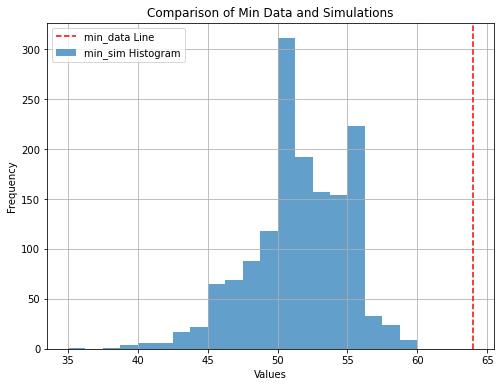

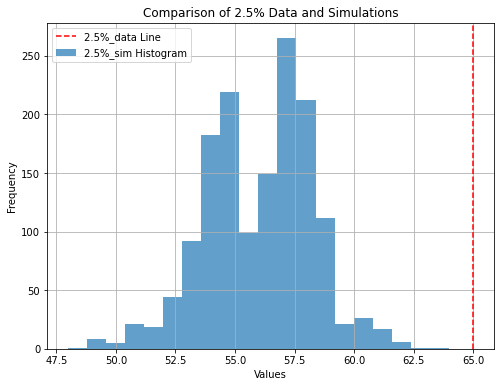

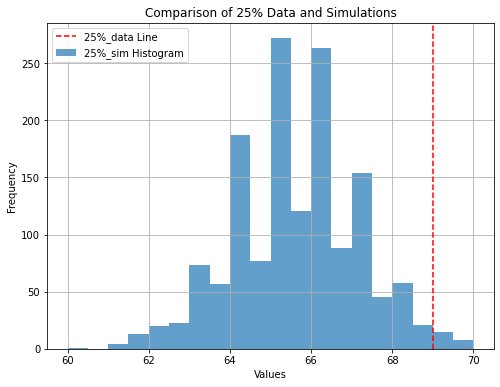

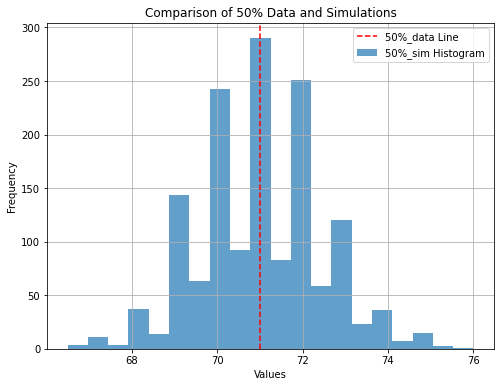

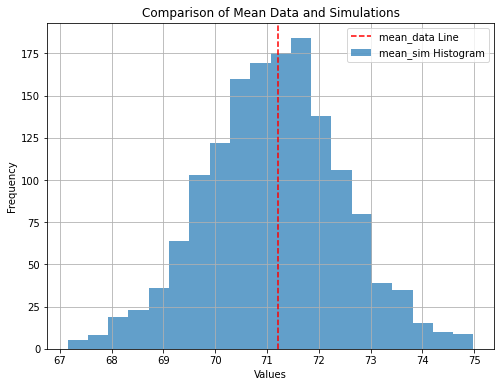

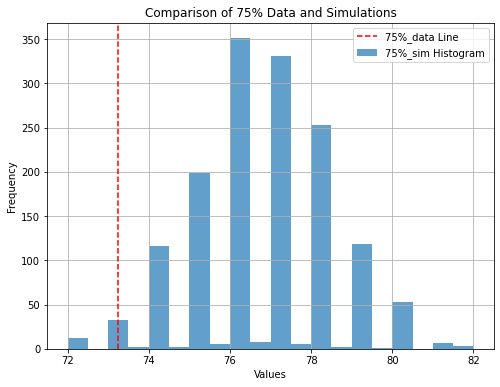

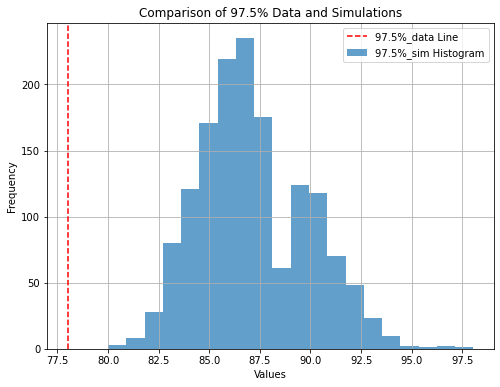

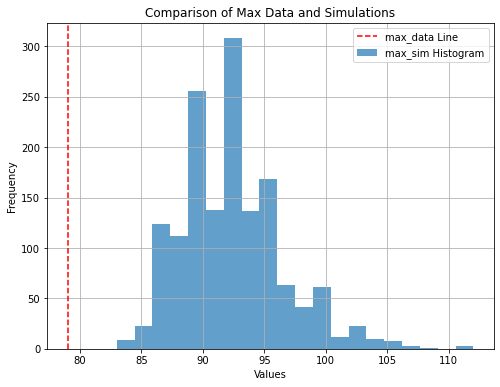

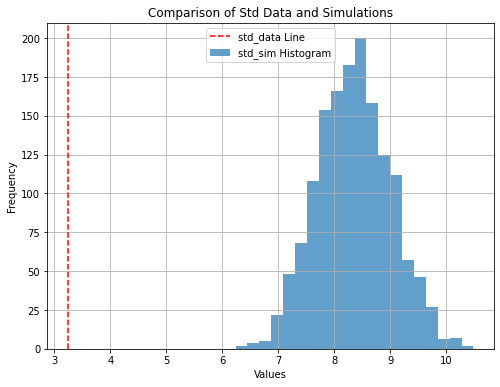

In [22]:
# Fit generated data to compare against actual data

import numpy as np


# Define statistics to loop through
# Will have 1k values for each value 
# Taking the min of 80 obs 
statistics = {
    'min': (np.min(observed_round_score), np.min(y_sim, axis=1)),
    '2.5%': (np.percentile(observed_round_score,2.5),np.percentile(y_sim,2.5,axis=1)),
    '25%': (np.percentile(observed_round_score,25),np.percentile(y_sim,25,axis=1)),
    '50%': (np.percentile(observed_round_score,50),np.percentile(y_sim,50,axis=1)),
    'mean': (np.mean(observed_round_score), np.mean(y_sim, axis=1)),
    '75%': (np.percentile(observed_round_score,75),np.percentile(y_sim,75,axis=1)),
    '97.5%': (np.percentile(observed_round_score,97.5),np.percentile(y_sim,97.5,axis=1)),
    'max': (np.max(observed_round_score), np.max(y_sim, axis=1)),
    'std': (np.std(observed_round_score), np.std(y_sim, axis=1))
}

# Plotting loop
for stat_name, (data_value, sim_values) in statistics.items():
    plt.figure(figsize=(8, 6))
    plt.axvline(x=data_value, color='r', linestyle='--', label=f'{stat_name}_data Line')
    plt.hist(sim_values, bins=20, alpha=0.7, label=f'{stat_name}_sim Histogram')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(f'Comparison of {stat_name.capitalize()} Data and Simulations')
    plt.legend()
    plt.grid()

